# Supervised Baselines

In [6]:
import sys
sys.path.append('../')
from corpus_WiNER.corpus_utils import *
import ast
import glob
import numpy as np
import pandas as pd
import keras.backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling1D, Input, concatenate
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Lambda, Embedding, TimeDistributed
from keras import regularizers, optimizers
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns

# MLP 

Utilizando la estrategia de decaimiento exponencial.

### Cargamos los datos pre-procesados y los filtramos para obtener:

- 100000 instancias de train
- &nbsp; 20000 instancias de dev
- &nbsp; 20000 instancias de test

In [2]:
word_vectors = np.load('./corpus_WiNER/word_vectors/wv_train_exp_decay_W_5.npz')
entity_vector = np.load('./corpus_WiNER/entity_vectors/ev_train_exp_decay_W_5.npz')
X_train = word_vectors.items()[0][1][:100000]
y_train = entity_vector.items()[0][1][:100000]
word_vectors = np.load('./corpus_WiNER/word_vectors/wv_dev_exp_decay_W_5.npz')
entity_vector = np.load('./corpus_WiNER/entity_vectors/ev_dev_exp_decay_W_5.npz')
X_dev = word_vectors.items()[0][1][:20000]
y_dev = entity_vector.items()[0][1][:20000]
word_vectors = np.load('./corpus_WiNER/word_vectors/wv_test_exp_decay_W_5.npz')
entity_vector = np.load('./corpus_WiNER/entity_vectors/ev_test_exp_decay_W_5.npz')
X_test = word_vectors.items()[0][1][:20000]
y_test = entity_vector.items()[0][1][:20000]

In [3]:
print('# word vectors:', len(X_train))
print('# non entities', list(y_train).count('O'))
print('# word vectors:', len(X_dev))
print('# non entities', list(y_dev).count('O'))
print('# word vectors:', len(X_test))
print('# non entities', list(y_test).count('O'))

# word vectors: 100000
# non entities 55825
# word vectors: 20000
# non entities 9634
# word vectors: 20000
# non entities 10410


In [4]:
y_train = [tagToInt(y) for y in y_train]
y_dev = [tagToInt(y) for y in y_dev]
y_test = [tagToInt(y) for y in y_test]
y_train[:10] # this transformation is needed to apply to_categorical() keras method

[0, 0, 0, 0, 2, 2, 2, 1, 1, 1]

In [5]:
num_classes = 5 # PER - LOC - ORG - MISC - O
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_dev = to_categorical(y_dev, num_classes)
y_test = to_categorical(y_test, num_classes)

In [16]:
nodes1 = 300
nodes2 = 512
lr = 0.001
l2 = 0.01
drop = 0.1

model = Sequential()    
model.add(Dense(nodes1,
                input_shape=(300,),
                activation = 'relu',
                kernel_regularizer = regularizers.l2(l2)
         )
)      
model.add(Dropout(drop))   

model.add(Dense(nodes2,
                activation = 'relu',
                kernel_regularizer = regularizers.l2(l2)))
model.add(Dense(nodes2,
                activation = 'relu',
                kernel_regularizer = regularizers.l2(l2)))

model.add(Dense(256,
                activation = 'relu',
                kernel_regularizer = regularizers.l2(l2)))
model.add(Dense(256,
                activation = 'relu',
                kernel_regularizer = regularizers.l2(l2)))


model.add(Dropout(drop))
model.add(Dense(128,
                activation = 'relu',
                kernel_regularizer = regularizers.l2(l2)))
model.add(Dense(5, activation = 'softmax')) # PER - LOC - ORG - MISC - O

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               154112    
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
__________

In [18]:
model.compile(optimizer = optimizers.Adadelta(lr = lr),
              loss = categorical_crossentropy,
              metrics = ['accuracy'])

In [19]:
batch_size = 512
epochs = 10

In [20]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_dev, y_dev))

Train on 100000 samples, validate on 20000 samples
Epoch 1/10
100000/100000 [==============================] - 4s 43us/step - loss: 21.1002 - acc: 0.1901 - val_loss: 21.0348 - val_acc: 0.3146
Epoch 2/10
100000/100000 [==============================] - 3s 34us/step - loss: 20.9520 - acc: 0.4330 - val_loss: 20.8860 - val_acc: 0.4757
Epoch 3/10
100000/100000 [==============================] - 3s 35us/step - loss: 20.7924 - acc: 0.5508 - val_loss: 20.7286 - val_acc: 0.4817
Epoch 4/10
100000/100000 [==============================] - 3s 34us/step - loss: 20.6237 - acc: 0.5582 - val_loss: 20.5644 - val_acc: 0.4817
Epoch 5/10
100000/100000 [==============================] - 3s 33us/step - loss: 20.4466 - acc: 0.5582 - val_loss: 20.3952 - val_acc: 0.4817
Epoch 6/10
100000/100000 [==============================] - 3s 34us/step - loss: 20.2633 - acc: 0.5582 - val_loss: 20.2245 - val_acc: 0.4817
Epoch 7/10
100000/100000 [==============================] - 3s 34us/step - loss: 20.0786 - acc: 0.5583 

# CNN Wide Model

Utilizando ventana simétrica de palabras que rodea a la objetivo.

### Cargamos los datos pre-procesados y los filtramos para obtener:

- 100000 instancias de train
- &nbsp; 20000 instancias de dev
- &nbsp; 20000 instancias de test

In [3]:
data_train = pd.read_csv('../corpus_WiNER/cnn_instances/words_entity_W_5_cnn_train.csv')
data_dev = pd.read_csv('../corpus_WiNER/cnn_instances/words_entity_W_5_cnn_dev.csv')
data_test = pd.read_csv('../corpus_WiNER/cnn_instances/words_entity_W_5_cnn_test.csv')
data_train.head()

,words,entityType
0,"['', '', '', '', '', 'Watching', 'Ellie', 'is'...",MISC
1,"['', '', '', '', 'Watching', 'Ellie', 'is', 'a...",MISC
2,"['', '', '', 'Watching', 'Ellie', 'is', 'an', ...",O
3,"['', 'Watching', 'Ellie', 'is', 'an', 'America...",LOC
4,"['an', 'American', 'sitcom', 'that', 'starred'...",PER


In [4]:
X_train = data_train['words'].values[:100000]
y_train = data_train['entityType'].values[:100000]
X_dev = data_dev['words'].values[:20000]
y_dev = data_dev['entityType'].values[:20000]
X_test = data_test['words'].values[:20000]
y_test = data_test['entityType'].values[:20000]

In [5]:
print('# instances:', len(X_train))
print('# non entities', list(y_train).count('O'))
print('# instances:', len(X_dev))
print('# non entities', list(y_dev).count('O'))
print('# instances:', len(X_test))
print('# non entities', list(y_test).count('O'))

# instances: 100000
# non entities 54508
# instances: 20000
# non entities 9590
# instances: 20000
# non entities 10856


In [6]:
y_train = [tagToInt(y) for y in y_train]
y_dev = [tagToInt(y) for y in y_dev]
y_test = [tagToInt(y) for y in y_test]
y_train[:10] # this transformation is needed to apply to_categorical() keras method

[3, 3, 4, 1, 0, 0, 0, 0, 4, 2]

In [7]:
def transform_input(instances, mapping):
    """Replaces the words in instances with their index in mapping.
    Args:
        instances: a list of text instances.
        mapping: an dictionary from words to indices.
    Returns:
        A matrix with shape (n_instances, m_words)."""
    word_indices = []
    for instance in instances:
        l = []
        for word in ast.literal_eval(instance):
            try:
                l.append(mapping[word].index)
            except KeyError:
                l.append(0) # index to '</s>' word vector
        word_indices.append(l)
        
    return word_indices

In [8]:
w2v_model = KeyedVectors.load('../models/google/word2vecGoogle.model')

In [9]:
X_train = transform_input(X_train, w2v_model.vocab)
X_dev = transform_input(X_dev, w2v_model.vocab)
X_test = transform_input(X_test, w2v_model.vocab)

In [10]:
batch_size = 512  # For mini-batch gradient descent
num_classes = 5 # PER - LOC - ORG - MISC - O
epochs = 10
len_words = 11
input_size = len_words # amount of words by row
train_examples = len(X_train)
test_examples = len(X_test)
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_dev = to_categorical(y_dev, num_classes)
y_test = to_categorical(y_test, num_classes)

In [11]:
# https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d
steps = 5 # number of words in the sentence
channels = 1
input_shape = (steps, channels) #3D tensor with shape: `(batch, steps, channels)`
# # Output shape
#     3D tensor with shape: `(batch, new_steps, filters)`
X_train = np.asarray(X_train)
X_dev = np.asarray(X_dev)
X_test = np.asarray(X_test)

In [12]:
X_train.shape

(100000, 11)

In [13]:
X_train[:5]

array([[    0,     0,     0,     0,     0, 14985, 28491,     4,    27,
          259, 17470],
       [    0,     0,     0,     0, 14985, 28491,     4,    27,   259,
        17470,     3],
       [    0,     0,     0, 14985, 28491,     4,    27,   259, 17470,
            3,  9483],
       [    0, 14985, 28491,     4,    27,   259, 17470,     3,  9483,
        10751,     0],
       [   27,   259, 17470,     3,  9483, 10751,     0,     0,    10,
         1088,    18]])

## Building CNN Wide Model

In [14]:
conv_filters = 10
pool_size = 2
inp = Input(shape=(X_train.shape[1],))
print(inp.shape)

(?, 11)


In [15]:
emb = Embedding(len(w2v_model.vocab),  # Vocabulary size
                w2v_model.vector_size, # Embedding size
                weights=[w2v_model.vectors], # Word vectors
                trainable=False  # This indicates the word vectors must not be changed
                                 # during training.
      )(inp)
print(emb.shape)
# The output here has shape (batch_size (?), words_in_reviews (?), embedding_size)

(?, 11, 300)


In [16]:
# Input shape
#     3D tensor with shape: `(batch, steps, channels)`

# Output shape
#     3D tensor with shape: `(batch, new_steps, filters)`
#     `steps` value might have changed due to padding or strides.

# Specify each convolution layer and their kernel size i.e. n-grams 
conv1_1 = Conv1D(filters=conv_filters, kernel_size=2, activation='relu')(emb)
btch1_1 = BatchNormalization()(conv1_1)
maxp1_1 = MaxPooling1D(pool_size=pool_size)(btch1_1)
flat1_1 = Flatten()(maxp1_1)

conv1_2 = Conv1D(filters=conv_filters, kernel_size=3, activation='relu')(emb)
btch1_2 = BatchNormalization()(conv1_2)
maxp1_2 = MaxPooling1D(pool_size=pool_size)(btch1_2)
flat1_2 = Flatten()(maxp1_2)

conv1_3 = Conv1D(filters=conv_filters, kernel_size=4, activation='relu')(emb)
btch1_3 = BatchNormalization()(conv1_3)
maxp1_3 = MaxPooling1D(pool_size=pool_size)(btch1_3)
flat1_3 = Flatten()(maxp1_3)

# Gather all convolution layers
cnct = concatenate([flat1_1, flat1_2, flat1_3], axis=1)
drp1 = Dropout(0)(cnct)

dns1  = Dense(128, activation='relu')(drp1)
out = Dense(num_classes, activation='softmax')(dns1)

In [17]:
model = Model(inputs=inp, outputs=out)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 11, 300)      900000000   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 10)       6010        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 9, 10)        9010        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [19]:
model.compile(loss=categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_dev, y_dev))

Train on 100000 samples, validate on 20000 samples
Epoch 1/10
100000/100000 [==============================] - 4s 45us/step - loss: 0.6723 - acc: 0.7624 - val_loss: 0.6417 - val_acc: 0.7818
Epoch 2/10
100000/100000 [==============================] - 2s 23us/step - loss: 0.4624 - acc: 0.8403 - val_loss: 0.6147 - val_acc: 0.7924
Epoch 3/10
100000/100000 [==============================] - 2s 25us/step - loss: 0.4029 - acc: 0.8614 - val_loss: 0.6146 - val_acc: 0.7967
Epoch 4/10
100000/100000 [==============================] - 2s 24us/step - loss: 0.3598 - acc: 0.8762 - val_loss: 0.6494 - val_acc: 0.7862
Epoch 5/10
100000/100000 [==============================] - 2s 24us/step - loss: 0.3248 - acc: 0.8891 - val_loss: 0.6492 - val_acc: 0.7893
Epoch 6/10
100000/100000 [==============================] - 2s 25us/step - loss: 0.2949 - acc: 0.8977 - val_loss: 0.6966 - val_acc: 0.7839
Epoch 7/10
100000/100000 [==============================] - 2s 25us/step - loss: 0.2689 - acc: 0.9073 - val_loss: 0

## Visualizamos los resultados de los experimentos

In [135]:
exp_dirs = glob.glob('../models/experiments/cnn_wide_supervised*')
df_list = []
for exp_dir in exp_dirs:
    df = pd.read_csv(exp_dir + '/' + 'train_logs.csv')
    exp_name = exp_dir.split('experiments/')[1]
    df['exp_name'] = exp_name
    df['train_examples_rate'] = exp_name.split('train_examples_rate_')[1].split('_')[0]
    df_list.append(df)
df = pd.concat(df_list, axis = 0, ignore_index = True)

In [136]:
acc_train_val = df.filter(items=['epoch', 'acc', 'val_acc', 'train_examples_rate'])
loss_train_val = df.filter(items=['epoch', 'loss', 'val_loss', 'train_examples_rate'])
acc_train_val = acc_train_val.melt(id_vars=['epoch', 'train_examples_rate'],
                                   var_name='metrics', value_name='accuracy')
loss_train_val = loss_train_val.melt(id_vars=['epoch', 'train_examples_rate'],
                                     var_name='metrics', value_name='loss')

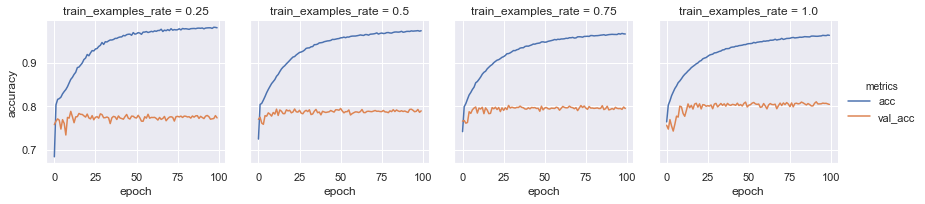

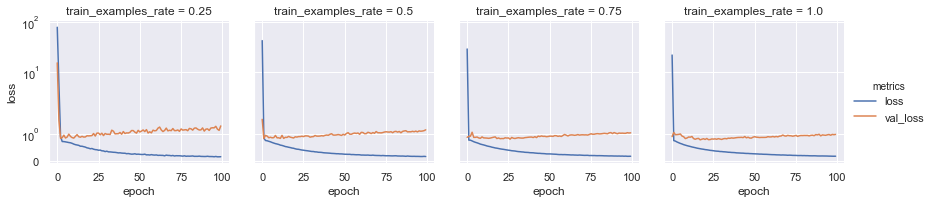

In [137]:
sns.set(style='darkgrid')
g = sns.FacetGrid(acc_train_val, col='train_examples_rate', hue='metrics',
                  col_order=['0.25', '0.5', '0.75', '1.0'])
g.map(plt.plot, 'epoch', 'accuracy').add_legend()
g = sns.FacetGrid(loss_train_val, col='train_examples_rate', hue='metrics',
                 col_order=['0.25', '0.5', '0.75', '1.0'])
plt.yscale('symlog') # ['linear' | 'log' | 'logit' | 'symlog']
g.map(plt.plot, 'epoch', 'loss').add_legend()

In [2]:
test_data = pd.read_csv('../corpus_WiNER/cnn_instances/words_entity_W_2_cnn_test.csv')
X_test = test_data['words'].values[:20000]
y_test = test_data['entityType'].values[:20000]
w2v_model = KeyedVectors.load('../models/google/word2vecGoogle.model')
from models.cnn_wide_baseline import transform_input
X_test = np.asarray(transform_input(X_test, w2v_model.vocab))
y_test = [tagToInt(y) for y in y_test]
y_test = to_categorical(y_test, 5)

In [3]:
from models.cnn_wide_baseline import build_model
from argparse import Namespace
args = Namespace(num_filters=100, pool_size=1, drop=0.5, l2=1)
best_model = build_model(h_params=args, input_shape=(X_test.shape[1], ), w2v_model=w2v_model)

In [11]:
def test_eval(X_test, y_test, best_model, exp_name, weights_filename):
    thedir = '../models/experiments/'
    # Loading best model snapshot weights
    best_model.load_weights(thedir + exp_name + '/' + weights_filename)
    best_model.compile(
        loss=categorical_crossentropy,
        optimizer='adadelta',
        metrics=['accuracy'])
    results = best_model.evaluate(X_test, y_test)
    print('test loss:', results[0])
    print('test acc:', results[1])

In [12]:
df.exp_name.unique()

array(['cnn_wide_supervised_l2_1.0_drop_0.5_num_filters_100_epochs_100_train_examples_rate_0.75_batch_size_512_pool_size_1',
       'cnn_wide_supervised_l2_1.0_train_examples_rate_0.5_epochs_100_drop_0.5_batch_size_512_pool_size_1_num_filters_100',
       'cnn_wide_supervised_train_examples_rate_1.0_epochs_100_drop_0.5_l2_1.0_pool_size_1_num_filters_100_batch_size_512',
       'cnn_wide_supervised_l2_1.0_batch_size_512_num_filters_100_epochs_100_train_examples_rate_0.25_drop_0.5_pool_size_1'],
      dtype=object)

In [13]:
print('Train examples rate 25%')
test_eval(X_test, y_test, best_model, df.exp_name.unique()[3], 'weights.03-0.83.hdf5')
print('Train examples rate 50%')
test_eval(X_test, y_test, best_model, df.exp_name.unique()[1], 'weights.02-0.82.hdf5')
print('Train examples rate 75%')
test_eval(X_test, y_test, best_model, df.exp_name.unique()[0], 'weights.29-0.83.hdf5')
print('Train examples rate 100%')
test_eval(X_test, y_test, best_model, df.exp_name.unique()[2], 'weights.92-0.95.hdf5')

Train examples rate 25%
20000/20000 [==============================] - 3s 137us/step
test loss: 0.7568062526941299
test acc: 0.79275
Train examples rate 50%
20000/20000 [==============================] - 2s 106us/step
test loss: 0.7488964944839478
test acc: 0.7984
Train examples rate 75%
20000/20000 [==============================] - 2s 105us/step
test loss: 0.7685598717212677
test acc: 0.8193
Train examples rate 100%
20000/20000 [==============================] - 2s 103us/step
test loss: 0.8765733576774597
test acc: 0.8271


# CNN Depth Model for Sequence Tagging

Ahora el input es cada oración y el output es una secuencia de etiquetas que asocia cada palabra de la oración con su respectiva etiqueta (PER - LOC - ORG - MISC - O). 

In [2]:
data_train = pd.read_csv('../corpus_WiNER/seq_tag_instances/sen_entities_max_len_30_train.csv')
data_val = pd.read_csv('../corpus_WiNER/seq_tag_instances/sen_entities_max_len_30_val.csv')
data_test = pd.read_csv('../corpus_WiNER/seq_tag_instances/sen_entities_max_len_30_test.csv')
data_train.head()

,entities,sentence
0,"['MISC', 'MISC', 'O', 'O', 'O', 'O', 'O', 'O',...","['General', 'relativity', ',', 'or', 'the', 'g..."
1,"['MISC', 'MISC', 'O', 'O', 'O', 'O', 'MISC', '...","['General', 'relativity', 'generalises', 'spec..."
2,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['In', 'particular', ',', 'the', 'curvature', ..."
3,"['O', 'O', 'O', 'O', 'O', 'O', 'MISC', 'MISC',...","['The', 'relation', 'is', 'specified', 'by', '..."
4,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['Some', 'predictions', 'of', 'general', 'rela..."


In [3]:
X_train = data_train['sentence'].map(lambda sen: np.array(ast.literal_eval(sen))).values
y_train = data_train['entities'].map(lambda sen: np.array(ast.literal_eval(sen))).values
X_val = data_val['sentence'].map(lambda sen: np.array(ast.literal_eval(sen))).values
y_val = data_val['entities'].map(lambda sen: np.array(ast.literal_eval(sen))).values
X_test = data_test['sentence'].map(lambda sen: np.array(ast.literal_eval(sen))).values
y_test = data_test['entities'].map(lambda sen: np.array(ast.literal_eval(sen))).values

In [4]:
print('#train:', len(X_train))
print('#val:', len(X_val))
print('#test:', len(X_test))

#train: 100000
#val: 20000
#test: 20000


In [5]:
fun = lambda y: tagToInt(y)
y_train = np.array([np.array(list(map(fun, labels))) for labels in y_train])
y_val = np.array([np.array(list(map(fun, labels))) for labels in y_val])
y_test = np.array([np.array(list(map(fun, labels))) for labels in y_test])

In [6]:
NUM_CLASSES = 5
MAX_SEN_LEN = 30

In [7]:
def transform_input(instances, mapping):
    """Replaces the words in instances with their index in mapping.
    Args:
        instances: a list of text instances.
        mapping: an dictionary from words to indices.
    Returns:
        A matrix with shape (n_instances, m_words)."""
    word_indices = []
    for instance in instances:
        l = []
        for word in instance:
            try:
                l.append(mapping[word].index)
            except KeyError:
                l.append(0) # index to '</s>' word vector
        word_indices.append(l)
        
    return pad_sequences(word_indices, maxlen=MAX_SEN_LEN)

In [8]:
w2v_model = KeyedVectors.load('../models/google/word2vecGoogle.model')

In [9]:
X_train = transform_input(X_train, w2v_model.vocab)
X_val = transform_input(X_val, w2v_model.vocab)
X_test = transform_input(X_test, w2v_model.vocab)

In [11]:
# convert class vectors to binary class matrices
y_train = np.array([to_categorical(labels, NUM_CLASSES) for labels in y_train])
y_val = np.array([to_categorical(labels, NUM_CLASSES) for labels in y_val])
y_test = np.array([to_categorical(labels, NUM_CLASSES) for labels in y_test])

In [12]:
print(y_train.shape)
print(pad_sequences(y_train, maxlen=MAX_SEN_LEN, # [0,0,0,0,1] one-hot encoding for 'O' label
                    value=np.array([0,0,0,0,1], dtype='float32')).shape)

(100000,)
(100000, 30, 5)


In [13]:
# padding target labels
y_train = pad_sequences(y_train, maxlen=MAX_SEN_LEN, # [0,0,0,0,1] one-hot encoding for 'O' label
                        value=np.array([0,0,0,0,1], dtype='float32'))
y_val = pad_sequences(y_val, maxlen=MAX_SEN_LEN, # [0,0,0,0,1] one-hot encoding for 'O' label
                      value=np.array([0,0,0,0,1], dtype='float32'))
y_test = pad_sequences(y_test, maxlen=MAX_SEN_LEN, # [0,0,0,0,1] one-hot encoding for 'O' label
                       value=np.array([0,0,0,0,1], dtype='float32'))

### Building CNN Depth Model

In [15]:
conv_filters = 100
batch_size = 1024
epochs = 100

In [16]:
inp = Input(shape=(X_train.shape[1],))
emb = Embedding(len(w2v_model.vocab),  # Vocabulary size
                w2v_model.vector_size, # Embedding size
                weights=[w2v_model.vectors], # Word vectors
                trainable=False  # This indicates the word vectors must not be changed
                                 # during training.
      )(inp)

In [17]:
conv1_1 = Conv1D(filters=conv_filters, kernel_size=2, padding='same', activation='relu')(emb)
drp1 = Dropout(0.5)(conv1_1)
out = TimeDistributed(Dense(NUM_CLASSES, activation="softmax"))(drp1)
model = Model(inputs=inp, outputs=out)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           900000000 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 100)           60100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 5)             505       
Total params: 900,060,605
Trainable params: 60,605
Non-trainable params: 900,000,000
_________________________________________________________________


In [19]:
model.compile(loss=categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Train on 100000 samples, validate on 20000 samples
Epoch 1/100
100000/100000 [==============================] - 3s 34us/step - loss: 0.6494 - acc: 0.8783 - val_loss: 0.3253 - val_acc: 0.9033
Epoch 2/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.2727 - acc: 0.9210 - val_loss: 0.2606 - val_acc: 0.9215
Epoch 3/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.2418 - acc: 0.9294 - val_loss: 0.2474 - val_acc: 0.9260
Epoch 4/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.2318 - acc: 0.9326 - val_loss: 0.2412 - val_acc: 0.9290
Epoch 5/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.2264 - acc: 0.9343 - val_loss: 0.2375 - val_acc: 0.9303
Epoch 6/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.2228 - acc: 0.9355 - val_loss: 0.2348 - val_acc: 0.9312
Epoch 7/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.2205 - acc: 0.9363 - val_

Epoch 59/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.1996 - acc: 0.9420 - val_loss: 0.2185 - val_acc: 0.9359
Epoch 60/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.1995 - acc: 0.9420 - val_loss: 0.2183 - val_acc: 0.9359
Epoch 61/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.1994 - acc: 0.9421 - val_loss: 0.2184 - val_acc: 0.9360
Epoch 62/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.1991 - acc: 0.9422 - val_loss: 0.2184 - val_acc: 0.9359
Epoch 63/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.1991 - acc: 0.9422 - val_loss: 0.2182 - val_acc: 0.9359
Epoch 64/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.1989 - acc: 0.9423 - val_loss: 0.2181 - val_acc: 0.9360
Epoch 65/100
100000/100000 [==============================] - 2s 20us/step - loss: 0.1989 - acc: 0.9422 - val_loss: 0.2182 - val_acc: 0.9360
Epoch 66/100


In [21]:
performance = model.evaluate(X_test, y_test)

20000/20000 [==============================] - 1s 42us/step


In [22]:
performance

[0.2073960896730423, 0.9378216666221618]

## Eligamos el mejor modelo

In [119]:
exp_dirs = glob.glob('../models/experiments/seq_tag_cnn_depth_supervised*')
df_list = []
for exp_dir in exp_dirs:
    df = pd.read_csv(exp_dir + '/' + 'train_logs.csv')
    exp_name = exp_dir.split('experiments/')[1]
    df['exp_name'] = exp_name
    df['train_examples_rate'] = exp_name.split('train_examples_rate_')[1].split('_')[0]
    df['conv_layers'] = exp_name.split('conv_layers_')[1].split('_')[0]
    df['conv_filters'] = exp_name.split('conv_filters_')[1].split('_')[0]
    df['l2'] = exp_name.split('l2_')[1].split('_')[0]
    df_list.append(df)
df = pd.concat(df_list, axis = 0, ignore_index = True)

In [120]:
# df.sort_values(by='val_acc', ascending=False).head(10)

In [121]:
conv_layers_1.l2.unique()

array(['0.5', '0.0'], dtype=object)

In [122]:
reg_0 = df[df.l2 == '0.0']
reg_0_5 = df[df.l2 == '0.5']

In [123]:
def plotear(df):
    acc_train_val = df.filter(items=['epoch', 'acc', 'val_acc', 'conv_layers', 'conv_filters'])
    loss_train_val = df.filter(items=['epoch', 'loss', 'val_loss', 'conv_layers', 'conv_filters'])
    acc_train_val = acc_train_val.melt(id_vars=['epoch', 'conv_layers', 'conv_filters'],
                                       var_name='metrics', value_name='accuracy')
    loss_train_val = loss_train_val.melt(id_vars=['epoch', 'conv_layers', 'conv_filters'],
                                         var_name='metrics', value_name='loss')
    sns.set(style='darkgrid')
    g = sns.FacetGrid(acc_train_val, row='conv_filters', col='conv_layers', hue='metrics',
                      row_order=['10', '50', '100'],
                      col_order=['1', '3', '5', '10'])
    g.map(plt.plot, 'epoch', 'accuracy').add_legend()
    g = sns.FacetGrid(loss_train_val, row='conv_filters', col='conv_layers', hue='metrics',
                      row_order=['10', '50', '100'],
                      col_order=['1', '3', '5', '10'])
    plt.yscale('log') # ['linear' | 'log' | 'logit' | 'symlog']
    g.map(plt.plot, 'epoch', 'loss').add_legend()

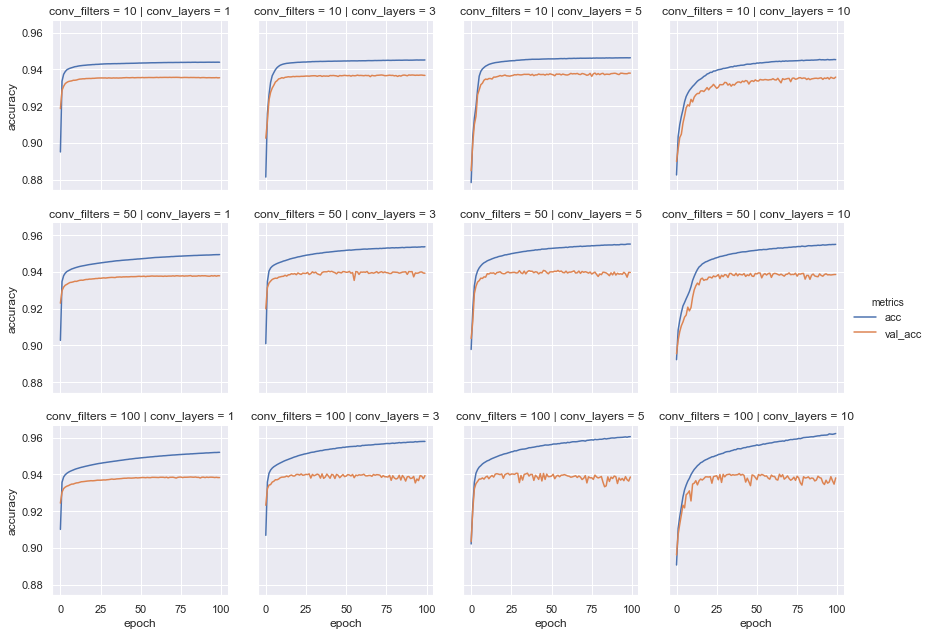

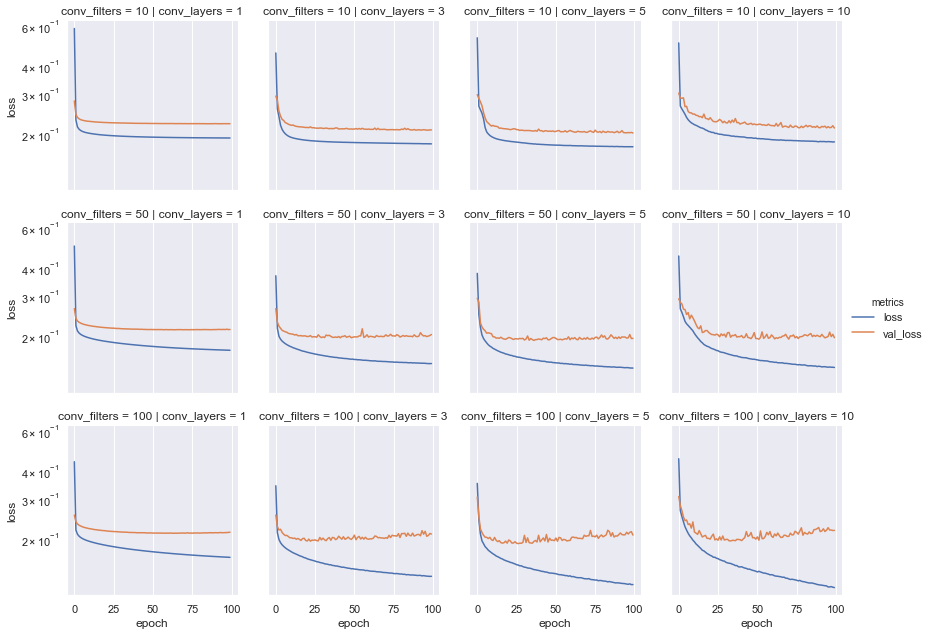

In [124]:
plotear(reg_0)

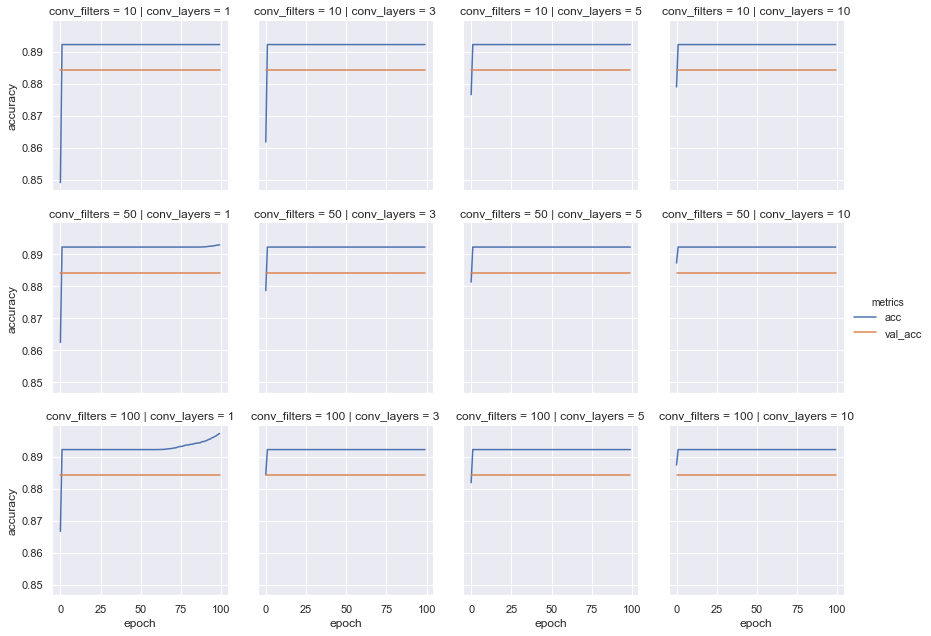

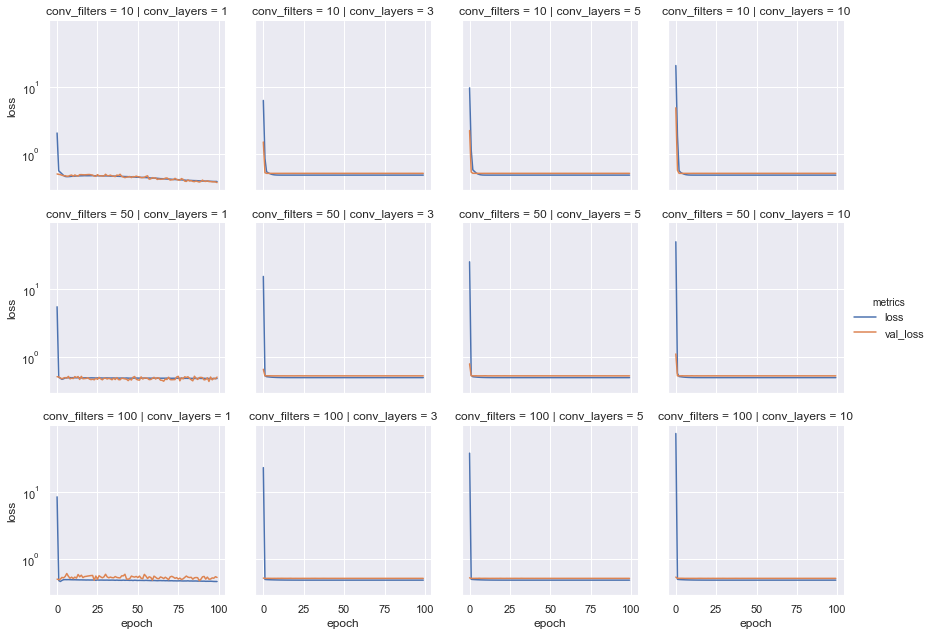

In [125]:
plotear(reg_0_5)